In [ ]:
#This file shows an implementation of MLP to create random sentences. I Cap the sentence to 10k for computational reasons.
#You can download dataset from  https://huggingface.co/datasets/Tom9358/tatoeba_21-dec-2024/resolve/main/eng_sentences.tsv.bz2

In [10]:
file = open('eng_sentences.tsv')
import torch
rawSentences = file.readlines()
refinedSentences = []

for sentence in rawSentences[:10000]:
    sentence = sentence.split('eng')[1]
    sentence = sentence.strip('\t')
    sentence = sentence.partition('\n')[0]
    sentence = sentence.rstrip('.')
    sentence = sentence.rstrip('?')
    sentence = sentence.rstrip('!')
    refinedSentences.append(sentence.lower())

refinedSentences[:5]

["let's try something",
 'i have to go to sleep',
 "today is june 18th and it is muiriel's birthday",
 'muiriel is 20 now',
 'the password is "muiriel"']

In [11]:
len(refinedSentences), len(rawSentences)

(10000, 1983396)

In [12]:
#We will convert each unique words into a number by iterating through all the words

import math
word_to_index = {}
words = set()
for sentence in refinedSentences:
    for word in sentence.split(' '):
        words.add(word)
words = list(words)

In [13]:
word_to_index = dict(zip(words, range(2, len(words) + 2)))
word_to_index['<s>'] = 0
word_to_index['<e>'] = 1

index_to_word = {index:word for word, index in word_to_index.items()}

In [14]:
len(words)

8032

In [15]:
def probabilityBigram(): #number of words after a certain word
    I = {} #ix counts
    B = {}

    for ix in range(len(refinedSentences)):
        sentence = refinedSentences[ix]
        words = sentence.split(' ')
        words = ['<s>'] + words + ['<e>']
        for wordix in range(len(words)-1):
            word1 = words[wordix]
            word2 = words[wordix + 1]
            ix1 = word_to_index[word1]
            ix2 = word_to_index[word2]

            if ix1 in I:
                I[ix1] += 1
            else:
                I[ix1] = 1

            if ix1 in B:
                if ix2 in B[ix1]:
                    B[ix1][ix2] += 1
                else:
                    B[ix1][ix2] = 1
            else:
                B[ix1] = {ix2 : 1}

    PB = {}

    for ix1 in B:
        for ix2 in B[ix1]:
            if ix1 not in PB: 
                PB[ix1] = {}
            PB[ix1][ix2] = B[ix1][ix2]/I[ix1]
            

    return PB
    
PB = probabilityBigram()


In [16]:
def build_dataset(dim):
    xs = []
    ys = []
    for ix in range(len(refinedSentences)):
        sentence = refinedSentences[ix]
        words = sentence.split(' ')
        words = ['<s>'] + words + ['<e>']
        for wordix in range(len(words)-1):
            word1 = words[wordix]
            word2 = words[wordix + 1]
            ix1 = word_to_index[word1]
            ix2 = word_to_index[word2]
            xs.append(ix1)
            ys.append(ix2)
    return torch.tensor(xs), torch.tensor(ys)
xs,ys = build_dataset(len(index_to_word))

In [17]:
xs.shape, ys.shape

(torch.Size([90931]), torch.Size([90931]))

In [18]:
xs[100:105], ys[100:105]

(tensor([2216,    0, 6768, 5222, 6469]),
 tensor([   1, 6768, 5222, 6469, 6727]))

In [19]:
from torch.nn import Embedding as embed
emb = embed(num_embeddings = len(word_to_index), embedding_dim = 128)


In [40]:
nn_layer1 = 64
nn_layer2 = 32
nn_layer3 = len(word_to_index)

W1 = torch.randn((128, nn_layer1))
B1 = torch.randn((1, nn_layer1))

W2 =torch.randn((nn_layer1, nn_layer2))
B2 = torch.randn((1, nn_layer2)) 

W3 =torch.randn((nn_layer2, nn_layer3))
B3 = torch.randn((1, nn_layer3)) 

params = [W1, B1, W2, B2, W3, B3]
for p in params:
    p.requires_grad = True

In [58]:
batch_size = 128
steps = []
loss = []
import random

for i in range(10000):
    #Batch the data
    batch_start = random.randint(0, len(xs)-32)
    batch_end = batch_start + batch_size
    samplexs = xs[batch_start : batch_end]
    sampleys = ys[batch_start : batch_end]

    #Forward Pass
    X = emb(samplexs)
    
    Z1 = (X @ W1) + B1
    O1 = torch.nn.functional.sigmoid(Z1)
    Z2 = (O1 @ W2) + B2
    O2 = torch.nn.functional.sigmoid(Z2)
    Z3 = (O2 @ W3) + B3
    preds = torch.nn.functional.softmax(Z3, dim=1)
    
    p = preds[torch.arange(len(preds)), sampleys]
    logp = p.log()
    nll = -logp.mean()

    #Reset gradients
    for p in params:
        p.grad = None
    
    nll.backward()
    
    for p in params:
        p.data -= 0.1* p.grad

    steps.append(i)
    loss.append(nll.item())

    if i % 1000 == 0:
        print(f"Step {i}, loss: {nll.item():.4f}")
nll



Step 0, loss: 7.0234
Step 1000, loss: 6.0658
Step 2000, loss: 6.7262
Step 3000, loss: 7.2871
Step 4000, loss: 6.0508
Step 5000, loss: 6.1623
Step 6000, loss: 5.5807
Step 7000, loss: 5.7357
Step 8000, loss: 5.7876
Step 9000, loss: 6.1293


tensor(5.7964, grad_fn=<NegBackward0>)

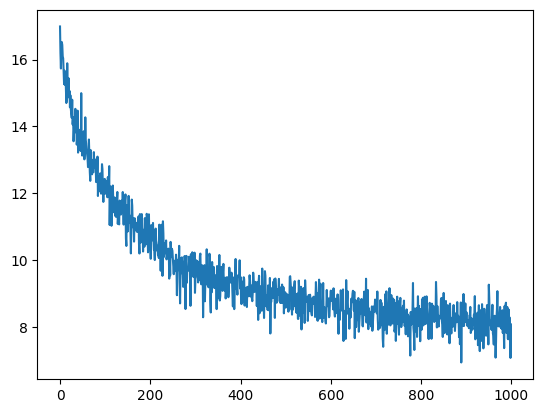

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(steps, loss)

In [107]:
#Sample from model!

x = emb(torch.tensor(0))
randomSentence = ''
out = None
while out != 1:
    
    Z1 = (x @ W1) + B1
    O1 = torch.nn.functional.sigmoid(Z1)
    Z2 = (O1 @ W2) + B2
    O2 = torch.nn.functional.sigmoid(Z2)
    Z3 = (O2 @ W3) + B3
    preds = torch.nn.functional.softmax(Z3, dim=1)
    out = torch.multinomial(preds, num_samples = 1, replacement = False).item()
    x = emb(torch.tensor(out))
    randomSentence += index_to_word[out] + ' ' if out != 1 else '.'

In [108]:
randomSentence

'our sorrow, know was voice like you go your differently, you holiday him aids of pollution was cured some weapons, .'

In [ ]:
#Of course the sentence is garbage cause MLP is not a very effective model!

In [ ]:
len(ys)